In [1]:
!pip install segmentation-models-pytorch --quiet
!pip install torch torchvision pillow tqdm matplotlib opencv-python

In [2]:
import os
import json
import cv2
import numpy as np
from PIL import Image
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [3]:
from google.colab import files
uploaded = files.upload()  # Upload Vehicle_Damage.zip

import zipfile
zip_path = 'archive (13).zip'
unzip_dir = 'Vehicle_Damage'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

In [36]:
def create_multiclass_masks_from_coco(coco_json, mask_folder):
    with open(coco_json, 'r') as f:
        coco = json.load(f)
    imgid_to_info = {img['id']: img for img in coco['images']}
    perimg_segments = defaultdict(list)
    all_classes = set()
    for ann in coco['annotations']:
        perimg_segments[ann['image_id']].append(ann)
        all_classes.add(ann['category_id'])
    num_classes = max(all_classes) + 1

    os.makedirs(mask_folder, exist_ok=True)
    for img_id, info in imgid_to_info.items():
        height, width = info['height'], info['width']
        mask = np.zeros((height, width), dtype=np.uint8)
        anns = perimg_segments.get(img_id, [])
        for ann in anns:
            cat = ann['category_id']
            if 'segmentation' in ann:
                for seg in ann['segmentation']:
                    coords = np.array(seg).reshape((-1, 2)).astype(np.int32)
                    cv2.fillPoly(mask, [coords], cat)
        mask_name = info['file_name'].replace('.jpg', '_mask.png')
        Image.fromarray(mask).save(os.path.join(mask_folder, mask_name))
    return num_classes

num_classes_train = create_multiclass_masks_from_coco(
    'Vehicle_Damage/train/COCO_mul_train_annos.json',
    'Vehicle_Damage/train/masks'
)
num_classes_val = create_multiclass_masks_from_coco(
    'Vehicle_Damage/val/COCO_mul_val_annos.json',
    'Vehicle_Damage/val/masks'
)
num_classes = max(num_classes_train, num_classes_val)

In [37]:
def compute_class_counts(mask_dir):
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    max_class = 0
    for mfile in mask_files:
        mask = np.array(Image.open(os.path.join(mask_dir, mfile)))
        this_max = mask.max()
        if this_max > max_class:
            max_class = this_max
    num_classes = max_class + 1
    class_counts = np.zeros(num_classes, dtype=np.int64)
    for mfile in mask_files:
        mask = np.array(Image.open(os.path.join(mask_dir, mfile)))
        for class_idx in range(num_classes):
            class_counts[class_idx] += np.sum(mask == class_idx)
    return class_counts

mask_dir = 'Vehicle_Damage/train/masks'
class_counts = compute_class_counts(mask_dir)
print("Pixel counts per class:", class_counts.tolist())


Pixel counts per class: [40698472, 1908459, 4714480, 5246303, 3489282, 5808988]


In [38]:
class CarDamageMulticlassSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(256, 256), aug=False, num_classes=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.aug = aug
        self.num_classes = num_classes
        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.resize = transforms.Resize(self.image_size)
        self.to_tensor = transforms.ToTensor()
    def augment(self, image, mask):
        if random.random() > 0.5:
            image, mask = TF.hflip(image), TF.hflip(mask)
        if random.random() > 0.9:
            image, mask = TF.vflip(image), TF.vflip(mask)
        angle = random.uniform(-15, 15)
        image, mask = TF.rotate(image, angle), TF.rotate(mask, angle)
        if random.random() > 0.7:
            image = TF.adjust_brightness(image, brightness_factor=random.uniform(0.8, 1.2))
            image = TF.adjust_contrast(image, contrast_factor=random.uniform(0.8, 1.2))
        return image, mask
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_name = self.images[idx]
        base = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, base + '_mask.png')
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        image = self.resize(image)
        mask = mask.resize(self.image_size, resample=Image.NEAREST)
        if self.aug:
            image, mask = self.augment(image, mask)
        image = self.to_tensor(image)
        mask_np = np.array(mask, dtype=np.uint8)
        mask_tensor = torch.from_numpy(mask_np).long()
        # --- Data checks
        if mask_tensor.min() < 0 or mask_tensor.max() >= self.num_classes:
            raise ValueError(
                f"Mask in {mask_path} out-of-range indices: {mask_tensor.min()} to {mask_tensor.max()}"
            )
        if mask_tensor.ndim != 2:
            raise ValueError(
                f"Mask in {mask_path} should have 2 dims, got {mask_tensor.shape}"
            )
        return image, mask_tensor


In [39]:
train_dataset = CarDamageMulticlassSegmentationDataset(
    image_dir='Vehicle_Damage/train',
    mask_dir='Vehicle_Damage/train/masks',
    aug=True,
    num_classes=num_classes
)
val_dataset = CarDamageMulticlassSegmentationDataset(
    image_dir='Vehicle_Damage/val',
    mask_dir='Vehicle_Damage/val/masks',
    aug=False,
    num_classes=num_classes
)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [40]:
import torch.nn as nn
import torch

weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
weights = weights / weights.sum()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = weights.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)


In [41]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name='resnet34',           # Or try: 'resnet50', 'efficientnet-b0', etc.
    encoder_weights='imagenet',        # Pretrained weights
    in_channels=3,
    classes=num_classes
).to(device)


In [42]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Debug: check classes in batch
        print("Batch GT classes:", torch.unique(masks).tolist())
        print("Batch pred classes:", torch.unique(outputs.argmax(dim=1)).tolist())
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
            print("Val GT classes:", torch.unique(masks).tolist())
            print("Val pred classes:", torch.unique(outputs.argmax(dim=1)).tolist())
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


 12%|█▎        | 1/8 [00:00<00:02,  3.32it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.63it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.83it/s]

Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.92it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.99it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.05it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 1/20, Train Loss: 1.9479


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.8295


 12%|█▎        | 1/8 [00:00<00:01,  4.09it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.82it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.55it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.41it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.33it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.30it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 2/20, Train Loss: 1.6622


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.7067


 12%|█▎        | 1/8 [00:00<00:01,  3.61it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.86it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.90it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.96it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.05it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.07it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.33it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 3/20, Train Loss: 1.5069


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.5911


 12%|█▎        | 1/8 [00:00<00:01,  4.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.16it/s]

Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.08it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.07it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.01it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 4/20, Train Loss: 1.3744


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.4430


 12%|█▎        | 1/8 [00:00<00:01,  4.18it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.18it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.15it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.15it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 5/20, Train Loss: 1.2977


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.3972


 12%|█▎        | 1/8 [00:00<00:01,  3.96it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 6/20, Train Loss: 1.1113


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.3809


 12%|█▎        | 1/8 [00:00<00:01,  4.18it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.15it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.17it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.09it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.14it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 7/20, Train Loss: 1.1456


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.3155


 12%|█▎        | 1/8 [00:00<00:02,  3.24it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.28it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.20it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.23it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.21it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.19it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:02<00:00,  3.48it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 8/20, Train Loss: 1.0603


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.2704


 12%|█▎        | 1/8 [00:00<00:01,  4.16it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.06it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.06it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.08it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 9/20, Train Loss: 0.9636


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.2630


 12%|█▎        | 1/8 [00:00<00:01,  4.07it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.10it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.13it/s]

Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.16it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 10/20, Train Loss: 0.9784


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.2266


 12%|█▎        | 1/8 [00:00<00:01,  4.14it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.14it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.14it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.43it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 11/20, Train Loss: 0.8745


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.1413


 12%|█▎        | 1/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.12it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.05it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.10it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.10it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.14it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.42it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 12/20, Train Loss: 0.8328


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.0799


 12%|█▎        | 1/8 [00:00<00:01,  4.19it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.10it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.36it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 13/20, Train Loss: 0.7830


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.0417


 12%|█▎        | 1/8 [00:00<00:02,  3.31it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.25it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.09it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.17it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.09it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 14/20, Train Loss: 0.7379


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 1.0611


 12%|█▎        | 1/8 [00:00<00:01,  4.19it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.16it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.12it/s]

Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 15/20, Train Loss: 0.7094


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.9978


 12%|█▎        | 1/8 [00:00<00:01,  4.09it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.10it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.11it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.06it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 16/20, Train Loss: 0.7466


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.9533


 12%|█▎        | 1/8 [00:00<00:01,  4.16it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.06it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.06it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.09it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.08it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.04it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 17/20, Train Loss: 0.7596


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.9840


 12%|█▎        | 1/8 [00:00<00:01,  4.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  4.03it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.07it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.10it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.10it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  4.05it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 18/20, Train Loss: 0.7170


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.9254


 12%|█▎        | 1/8 [00:00<00:01,  4.17it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.96it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  4.07it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:00<00:00,  4.13it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  4.16it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.76it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 19/20, Train Loss: 0.6169


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8563


 12%|█▎        | 1/8 [00:00<00:02,  3.17it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 25%|██▌       | 2/8 [00:00<00:01,  3.22it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 38%|███▊      | 3/8 [00:00<00:01,  3.24it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 50%|█████     | 4/8 [00:01<00:01,  3.26it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 62%|██████▎   | 5/8 [00:01<00:00,  3.51it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


 75%|███████▌  | 6/8 [00:01<00:00,  3.70it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]


100%|██████████| 8/8 [00:02<00:00,  3.87it/s]

Batch GT classes: [0, 1, 2, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Batch GT classes: [0, 1, 3, 4, 5]
Batch pred classes: [0, 1, 2, 3, 4, 5]
Epoch 20/20, Train Loss: 0.5981


Val GT classes: [0, 1, 2, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Val GT classes: [0, 1, 3, 4, 5]
Val pred classes: [0, 1, 2, 3, 4, 5]
Validation Loss: 0.8357


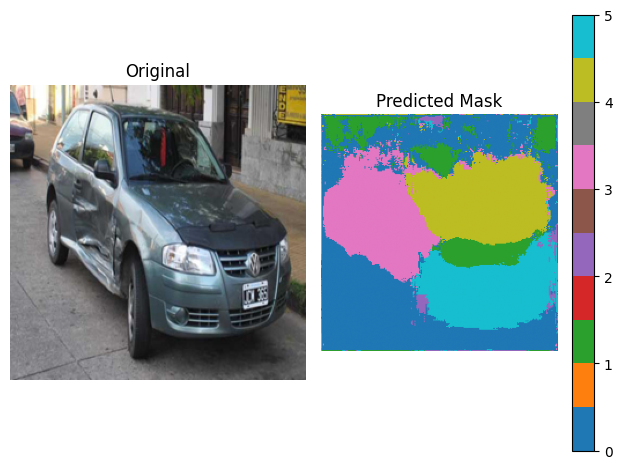

In [48]:
def show_multiclass_mask(model, img_path, device, num_classes):
    import torchvision.transforms as T
    model.eval()
    img = Image.open(img_path).convert('RGB').resize((256, 256))
    img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(img_tensor)
        pred = out.argmax(dim=1)[0].cpu().numpy()
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(pred, cmap='tab10', vmin=0, vmax=num_classes-1)
    plt.colorbar(ticks=range(num_classes))
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
show_multiclass_mask(model, 'Vehicle_Damage/test/28.jpg', device, num_classes)

###Mask Generation from COCO

In [13]:
def create_binary_masks_from_coco(coco_json, mask_folder):
    with open(coco_json, 'r') as f:
        coco = json.load(f)
    imgid_to_info = {img['id']: img for img in coco['images']}
    perimg_segments = defaultdict(list)
    for ann in coco['annotations']:
        perimg_segments[ann['image_id']].append(ann)
    os.makedirs(mask_folder, exist_ok=True)
    for img_id, info in imgid_to_info.items():
        height, width = info['height'], info['width']
        mask = np.zeros((height, width), dtype=np.uint8)
        anns = perimg_segments.get(img_id, [])
        for ann in anns:
            if 'segmentation' in ann:
                for seg in ann['segmentation']:
                    coords = np.array(seg).reshape((-1, 2)).astype(np.int32)
                    cv2.fillPoly(mask, [coords], color=1)
        mask_name = info['file_name'].replace('.jpg', '_mask.png')
        Image.fromarray(mask * 255).save(os.path.join(mask_folder, mask_name))

Generate mask

In [14]:
create_binary_masks_from_coco(
    coco_json='Vehicle_Damage/train/COCO_train_annos.json',
    mask_folder='Vehicle_Damage/train/masks'
)


###Calculate Pixel Class Balance for Binary Masks

In [15]:
def compute_binary_class_counts(mask_dir):
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    class_counts = np.zeros(2, dtype=np.int64)
    for mfile in mask_files:
        mask = np.array(Image.open(os.path.join(mask_dir, mfile)))
        class_counts[0] += np.sum(mask == 0)
        class_counts[1] += np.sum(mask > 0)
    return class_counts

mask_dir = 'Vehicle_Damage/train/masks'
class_counts = compute_binary_class_counts(mask_dir)
print("Pixel counts per class:", class_counts.tolist())  # [background_pixels, damage_pixels]


Pixel counts per class: [55770811, 6095173]


###Binary and Multiclass Segmentation Dataset

In [16]:
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
import random

class CarDamageBinarySegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(256, 256), aug=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.aug = aug
        self.images = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.resize = transforms.Resize(self.image_size)
        self.to_tensor = transforms.ToTensor()

    def augment(self, image, mask):
        if random.random() > 0.5:
            image, mask = TF.hflip(image), TF.hflip(mask)
        if random.random() > 0.9:
            image, mask = TF.vflip(image), TF.vflip(mask)
        angle = random.uniform(-15, 15)
        image, mask = TF.rotate(image, angle), TF.rotate(mask, angle)
        if random.random() > 0.7:
            image = TF.adjust_brightness(image, brightness_factor=random.uniform(0.8, 1.2))
            image = TF.adjust_contrast(image, contrast_factor=random.uniform(0.8, 1.2))
        return image, mask

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        base = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, base + '_mask.png')
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        image = self.resize(image)
        mask = mask.resize(self.image_size, resample=Image.NEAREST)
        if self.aug:
            image, mask = self.augment(image, mask)
        image = self.to_tensor(image)
        mask_np = np.array(mask, dtype=np.uint8)
        mask_tensor = torch.from_numpy((mask_np > 127).astype(np.float32))  # [H, W], float32; 0/1
        return image, mask_tensor.unsqueeze(0)  # [3,H,W], [1,H,W]


Create train & val loaders:

In [17]:
from torch.utils.data import DataLoader

train_dataset = CarDamageBinarySegmentationDataset(
    image_dir='Vehicle_Damage/train',
    mask_dir='Vehicle_Damage/train/masks',
    aug=True
)
val_dataset = CarDamageBinarySegmentationDataset(
    image_dir='Vehicle_Damage/val',
    mask_dir='Vehicle_Damage/val/masks',
    aug=False
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


###Weighted Loss for Class Imbalance

In [18]:
import torch.nn as nn
import torch

# Compute pos_weight for BCEWithLogitsLoss: (background / (damage + epsilon))
background, damage = class_counts
epsilon = 1e-6
pos_weight = torch.tensor([background / (damage + epsilon)], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pos_weight = pos_weight.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


Pretrained U-Net Model Initialization

In [19]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name='resnet34',      # Pretrained backbone
    encoder_weights='imagenet',   # Pretrained on ImageNet
    in_channels=3,
    classes=1                     # Binary mask output (1 channel)
).to(device)


In [20]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


100%|██████████| 8/8 [00:01<00:00,  4.38it/s]


Epoch 1/20, Train Loss: 1.4093
Validation Loss: 0.6623


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


Epoch 2/20, Train Loss: 1.1023
Validation Loss: 0.5788


100%|██████████| 8/8 [00:01<00:00,  4.04it/s]


Epoch 3/20, Train Loss: 0.8987
Validation Loss: 0.4952


100%|██████████| 8/8 [00:01<00:00,  4.19it/s]


Epoch 4/20, Train Loss: 0.8098
Validation Loss: 0.5250


100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


Epoch 5/20, Train Loss: 0.7430
Validation Loss: 0.5314


100%|██████████| 8/8 [00:01<00:00,  4.53it/s]


Epoch 6/20, Train Loss: 0.7130
Validation Loss: 0.5117


100%|██████████| 8/8 [00:01<00:00,  4.60it/s]


Epoch 7/20, Train Loss: 0.6443
Validation Loss: 0.5638


100%|██████████| 8/8 [00:01<00:00,  4.63it/s]


Epoch 8/20, Train Loss: 0.6258
Validation Loss: 0.5839


100%|██████████| 8/8 [00:01<00:00,  4.11it/s]


Epoch 9/20, Train Loss: 0.5954
Validation Loss: 0.4759


100%|██████████| 8/8 [00:01<00:00,  4.16it/s]


Epoch 10/20, Train Loss: 0.5655
Validation Loss: 0.4042


100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


Epoch 11/20, Train Loss: 0.5560
Validation Loss: 0.4346


100%|██████████| 8/8 [00:01<00:00,  4.61it/s]


Epoch 12/20, Train Loss: 0.5423
Validation Loss: 0.4424


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


Epoch 13/20, Train Loss: 0.5191
Validation Loss: 0.3994


100%|██████████| 8/8 [00:01<00:00,  4.59it/s]


Epoch 14/20, Train Loss: 0.5002
Validation Loss: 0.3380


100%|██████████| 8/8 [00:01<00:00,  4.22it/s]


Epoch 15/20, Train Loss: 0.4843
Validation Loss: 0.3583


100%|██████████| 8/8 [00:01<00:00,  4.01it/s]


Epoch 16/20, Train Loss: 0.4597
Validation Loss: 0.4323


100%|██████████| 8/8 [00:01<00:00,  4.66it/s]


Epoch 17/20, Train Loss: 0.5193
Validation Loss: 0.2638


100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


Epoch 18/20, Train Loss: 0.4278
Validation Loss: 0.3725


100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


Epoch 19/20, Train Loss: 0.4321
Validation Loss: 0.3258


100%|██████████| 8/8 [00:01<00:00,  4.65it/s]


Epoch 20/20, Train Loss: 0.4247
Validation Loss: 0.3274


In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2
import numpy as np
from PIL import Image

def show_mask_outline_on_image(model, img_path, device, threshold=0.5):
    # Load image and predict mask
    image = Image.open(img_path).convert('RGB').resize((256, 256))
    image_tensor = T.ToTensor()(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = torch.sigmoid(model(image_tensor))
        pred_mask = (out[0, 0].cpu().numpy() > threshold).astype(np.uint8)

    img_disp = np.array(image)
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_contours = img_disp.copy()
    cv2.drawContours(img_with_contours, contours, -1, (0, 0, 255), thickness=2)
    img_with_contours = cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img_with_contours)
    plt.title("Predicted Damage Outline")
    plt.axis('off')
    plt.show()


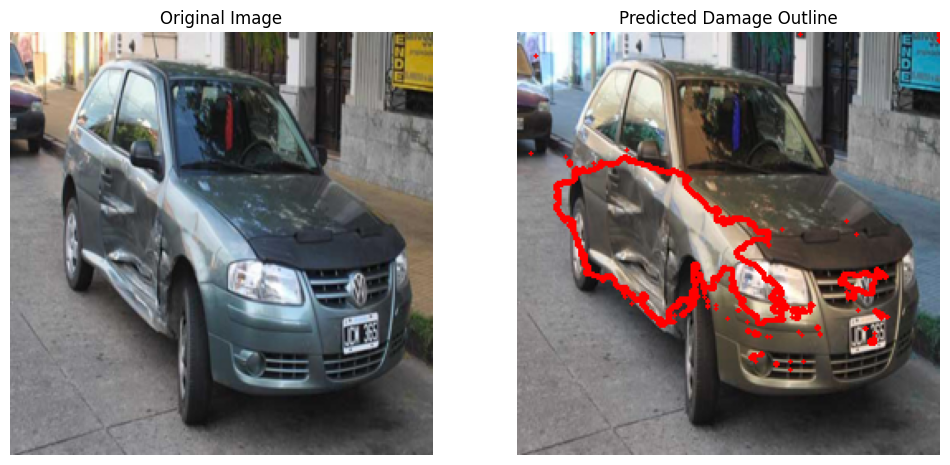

In [22]:
show_mask_outline_on_image(model, 'Vehicle_Damage/test/28.jpg', device, threshold=0.5)